In [1]:
#data analysis
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import imageio

#models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge

#model validation and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from scipy.stats import gaussian_kde, randint, uniform

#os and pathing
import os
from pathlib import Path

In [2]:
solar = pd.read_csv("rhessi_full2002_2018_filtered.csv")

In [ ]:
'''
Creates intensity target attribute through avg of energy.kev * duration.s
- takes a dataframe and returns dataframe with added 'intensity' column
'''

def addIntensity(data):
    avg_energy = (data['energy.kev.f'] + data['energy.kev.i'])/2
    data['intensity'] = avg_energy * data['duration.s']
    return data

#method 1's:

M1 = XGBRegressor(learning_rate= 0.248, max_depth= 10, n_estimators= 546)

y = solar[["total.counts"]]
X = solar[['duration.s', 'peak.c/s', 'x.pos.asec',
           'y.pos.asec', 'radial', 'energy.kev.i',
           'energy.kev.f', 'day','month','year','active.region.ar']]

M1.fit(X, y)

#method 2's:
solar = addIntensity(solar)
M2 = RandomForestRegressor()

y = solar[["intensity"]]
X = solar[['day','month','year','active.region.ar', 'peak.c/s', 'total.counts', 'x.pos.asec', 'y.pos.asec', 'radial']]

M2.fit(X, y)

In [4]:
#solar flare data from 2004 and 2005
solar_2004_2005 = solar[(solar['year'] == 2004) | (solar['year'] == 2005)]

#solar flare data from 2015 and 2016
solar_2015_2016 = solar[(solar['year'] == 2015) | (solar['year'] == 2016)]

In [5]:
#Make Batches Function
def make_batches(data, start_year, end_year):
    batches = []
    for start_month in range(1, 12, 2):
        batch = data[
            (data['year'] == start_year) & (data['month'].between(start_month, start_month + 3))]
        if len(batches) == 5:
            batch = data[
                ((data['year'] == start_year) & data['month'].between(start_month, start_month + 3)) |
                ((data['year'] == end_year) & data['month'].between(1, 2))
            ]
        batches.append(batch)

    for start_month in range(1, 12, 2):
        batch = data[
            (data['year'] == end_year) & data['month'].between(start_month, start_month + 3)]
        if len(batches) <= 10: 
            batches.append(batch)
    return batches

In [6]:
batches2004_2005 = make_batches(solar_2004_2005, 2004, 2005)
batches2015_2016 = make_batches(solar_2015_2016, 2015, 2016)

In [ ]:
# Batches 0 and 10 for the year 2004-2005
# Naming convention should follow: batchN_methodN_2004_2005
# batch0 1+2+3+4 (also known as batch 1)
batch0_method1_2004_2005 = batches2004_2005[0][['duration.s', 'peak.c/s', 'x.pos.asec',
                                'y.pos.asec', 'radial', 'energy.kev.i',
                                'energy.kev.f', 'day','month','year','active.region.ar']]
                                
batch0_method2_2004_2005 = batches2004_2005[0][['day','month','year','active.region.ar', 'peak.c/s',
                            'total.counts', 'x.pos.asec', 'y.pos.asec', 'radial']]

# batch10 21+22+23+24 (also known as batch 11) 
batch10_method1_2004_2005 = batches2004_2005[10][['duration.s', 'peak.c/s', 'x.pos.asec',
                                'y.pos.asec', 'radial', 'energy.kev.i',
                                'energy.kev.f', 'day','month','year','active.region.ar']]

batch10_method2_2004_2005 = batches2004_2005[10][['day','month','year','active.region.ar', 'peak.c/s',
                            'total.counts', 'x.pos.asec', 'y.pos.asec', 'radial']]

# Batch 0 Method 1 2004_2005
batch0_method1_y_pred_2004_2005 = M1.predict(batch0_method1_2004_2005)
batch0_method1_2004_2005['intensity_pred'] = batch0_method1_y_pred_2004_2005

# Batch 0 Method 2 2004_2005
batch0_method2_y_pred_2004_2005 = M2.predict(batch0_method2_2004_2005)
batch0_method2_2004_2005['intensity_pred'] = batch0_method2_y_pred_2004_2005

# Batch 10 Method 1 2004_2005
batch10_method1_y_pred_2004_2005 = M1.predict(batch10_method1_2004_2005)
batch10_method1_2004_2005['intensity_pred'] = batch10_method1_y_pred_2004_2005

# Batch 10 Method 2 2004_2005
batch10_method2_y_pred_2004_2005 = M2.predict(batch10_method2_2004_2005)
batch10_method2_2004_2005['intensity_pred'] = batch10_method2_y_pred_2004_2005

In [ ]:
# Batches 0 and 10 for the year 2015-2016
# batch0
batch0_method1_2015_2016 = batches2015_2016[0][['duration.s', 'peak.c/s', 'x.pos.asec',
                                'y.pos.asec', 'radial', 'energy.kev.i',
                                'energy.kev.f', 'day','month','year','active.region.ar']]
                                
batch0_method2_2015_2016 = batches2015_2016[0][['day','month','year','active.region.ar', 'peak.c/s',
                            'total.counts', 'x.pos.asec', 'y.pos.asec', 'radial']]

# batch10
batch10_method1_2015_2016 = batches2015_2016[10][['duration.s', 'peak.c/s', 'x.pos.asec',
                                'y.pos.asec', 'radial', 'energy.kev.i',
                                'energy.kev.f', 'day','month','year','active.region.ar']]

batch10_method2_2015_2016 = batches2015_2016[10][['day','month','year','active.region.ar', 'peak.c/s',
                            'total.counts', 'x.pos.asec', 'y.pos.asec', 'radial']]

# Batch 0 Method 1 2015_2016
batch0_method1_y_pred_2015_2016 = M1.predict(batch0_method1_2015_2016)
batch0_method1_2015_2016['intensity_pred'] = batch0_method1_y_pred_2015_2016

# Batch 0 Method 2 2015_2016
batch0_method2_y_pred_2015_2016= M2.predict(batch0_method2_2015_2016)
batch0_method2_2015_2016['intensity_pred'] = batch0_method2_y_pred_2015_2016

# Batch 10 Method 1 2015_2016
batch10_method1_y_pred_2015_2016 = M1.predict(batch10_method1_2015_2016)
batch10_method1_2015_2016['intensity_pred'] = batch10_method1_y_pred_2015_2016

# Batch 10 Method 2 2015_2016
batch10_method2_y_pred_2015_2016 = M2.predict(batch10_method2_2015_2016)
batch10_method2_2015_2016['intensity_pred'] = batch10_method2_y_pred_2015_2016

In [ ]:
# Batch 5 Pred 2004_2005
batch5_method1_2004_2005 = batches2004_2005[5][['duration.s', 'peak.c/s', 'x.pos.asec',
                                'y.pos.asec', 'radial', 'energy.kev.i',
                                'energy.kev.f', 'day','month','year','active.region.ar']]
                                
batch5_method2_2004_2005 = batches2004_2005[5][['day','month','year','active.region.ar', 'peak.c/s',
                            'total.counts', 'x.pos.asec', 'y.pos.asec', 'radial']]

# Batch 5 Method 1 and 2 2004_2005
batch5_method1_y_pred_2004_2005 = M1.predict(batch5_method1_2004_2005)
batch5_method1_2004_2005['intensity_pred'] = batch5_method1_y_pred_2004_2005

batch5_method2_y_pred_2004_2005 = M2.predict(batch5_method2_2004_2005)
batch5_method2_2004_2005['intensity_pred'] = batch5_method2_y_pred_2004_2005

In [8]:
def split(solar_data):
    split1 = (np.percentile(solar_data, 20))
    split2 = (np.percentile(solar_data, 40))
    split3 = (np.percentile(solar_data, 60))
    split4 = (np.percentile(solar_data, 80))
    split5 = (np.percentile(solar_data, 99))
    return split1, split2, split3, split4, split5

# Name convention of data: batchN_methodN_startyear_endyear
# batch0_method1_2004_2005
# the data needs 'intensity_pred' column which is the batchN_methodN_y_pred_startyear_endyear values
# solar_data is the truth data from the solar either intensity calculated or total.counts.
# Method 1 requires solar["total.counts"] and Method 2 requires solar["intensity"]
# This makes a single plot that has all the data points
def intensity_map_scatter(data, solar_data , method_name, batch_name, year, transparent=True):
    
    split_intense = split(solar_data)

    colors = {
        'low': 'grey',
        'medlow': 'green',
        'med': 'yellow',
        'medhigh': 'orange',
        'high': 'red',
        'extreme': 'purple'
    }

    low = data[(data['intensity_pred'] <= split_intense[0])]
    medlow = data[(data['intensity_pred'] > split_intense[0]) & (data['intensity_pred'] <= split_intense[1])]
    med = data[(data['intensity_pred'] > split_intense[1]) & (data['intensity_pred'] <= split_intense[2])]
    medhigh = data[(data['intensity_pred'] > split_intense[2]) & (data['intensity_pred'] <= split_intense[3])]
    high = data[(data['intensity_pred'] > split_intense[3])]
    extreme = data[(data['intensity_pred'] > split_intense[4])]

    print(f"{method_name} - {batch_name} - {year}", "\n")
    print(f"Low: {len(low)}", f"MedLow: {len(medlow)}", f"Med: {len(med)}", f"MedHigh: {len(medhigh)}", f"High: {len(high)}", f"Extreme: {len(extreme)}", "\n")
    print("Total: ", len(low) + len(medlow) + len(med) + len(medhigh) + len(high) + len(extreme), "\n")

    plt.figure(figsize=(28, 26)) 
    plt.title(f"Solar Flare Intensity Map {method_name} - {batch_name} - {year}", fontsize=30)
    plt.xlabel('x.pos.asec', fontsize=30)
    plt.ylabel('y.pos.asec', fontsize=30)
    plt.xlim(-1050, 1050)
    plt.ylim(-1050, 1050) 
    plt.scatter(low['x.pos.asec'], low['y.pos.asec'], c=colors['low'], label='Low)')
    plt.scatter(medlow['x.pos.asec'], medlow['y.pos.asec'], c=colors['medlow'], label='MedLow')
    plt.scatter(med['x.pos.asec'], med['y.pos.asec'], c=colors['med'], label='Med')
    plt.scatter(medhigh['x.pos.asec'], medhigh['y.pos.asec'], c=colors['medhigh'], label='MedHigh')
    plt.scatter(high['x.pos.asec'], high['y.pos.asec'], c=colors['high'], label='High')
    plt.scatter(extreme['x.pos.asec'], extreme['y.pos.asec'], c=colors['extreme'], label='Extreme')
    plt.legend(loc='upper right', fontsize=25)

    # Save the plot as a png to folder
    folder_path = 'Intensity_Map_PNGS'
    os.makedirs(folder_path, exist_ok=True) # Make folder if it doesn't exist
    filename = os.path.join(folder_path, f'intensity_map_{method_name}_{batch_name}_{year}.png')
    plt.savefig(filename, transparent=transparent)
    plt.show()



In [ ]:
# Calls the function 4 times for batch0 and batch10 for both methods
# Batch 0 2004_2005           
intensity_map_scatter(batch0_method1_2004_2005, solar["total.counts"], 'Method 1','Batch0', '2004_2005', transparent=False)
intensity_map_scatter(batch0_method2_2004_2005, solar["intensity"], 'Method 2','Batch0', '2004_2005', transparent=False)
# Batch 10 2004_2005
intensity_map_scatter(batch10_method1_2004_2005, solar["total.counts"], 'Method 1','Batch10', '2004_2005', transparent=False)
intensity_map_scatter(batch10_method2_2004_2005, solar["intensity"], 'Method 2','Batch10', '2004_2005', transparent=False)

# Batch 0 2015_2016           
intensity_map_scatter(batch0_method1_2015_2016, solar["total.counts"], 'Method 1','Batch0', '2015_2016', transparent=False)
intensity_map_scatter(batch0_method2_2015_2016, solar["intensity"], 'Method 2','Batch0', '2015_2016', transparent=False)
# Batch 10 2015_2016
intensity_map_scatter(batch10_method1_2015_2016, solar["total.counts"], 'Method 1','Batch10', '2015_2016', transparent=False)
intensity_map_scatter(batch10_method2_2015_2016, solar["intensity"], 'Method 2','Batch10', '2015_2016', transparent=False)


Method 1 - Batch5 - 2004_2005 

Low: 573 MedLow: 638 Med: 592 MedHigh: 573 High: 641 Extreme: 49 

Total:  3066 



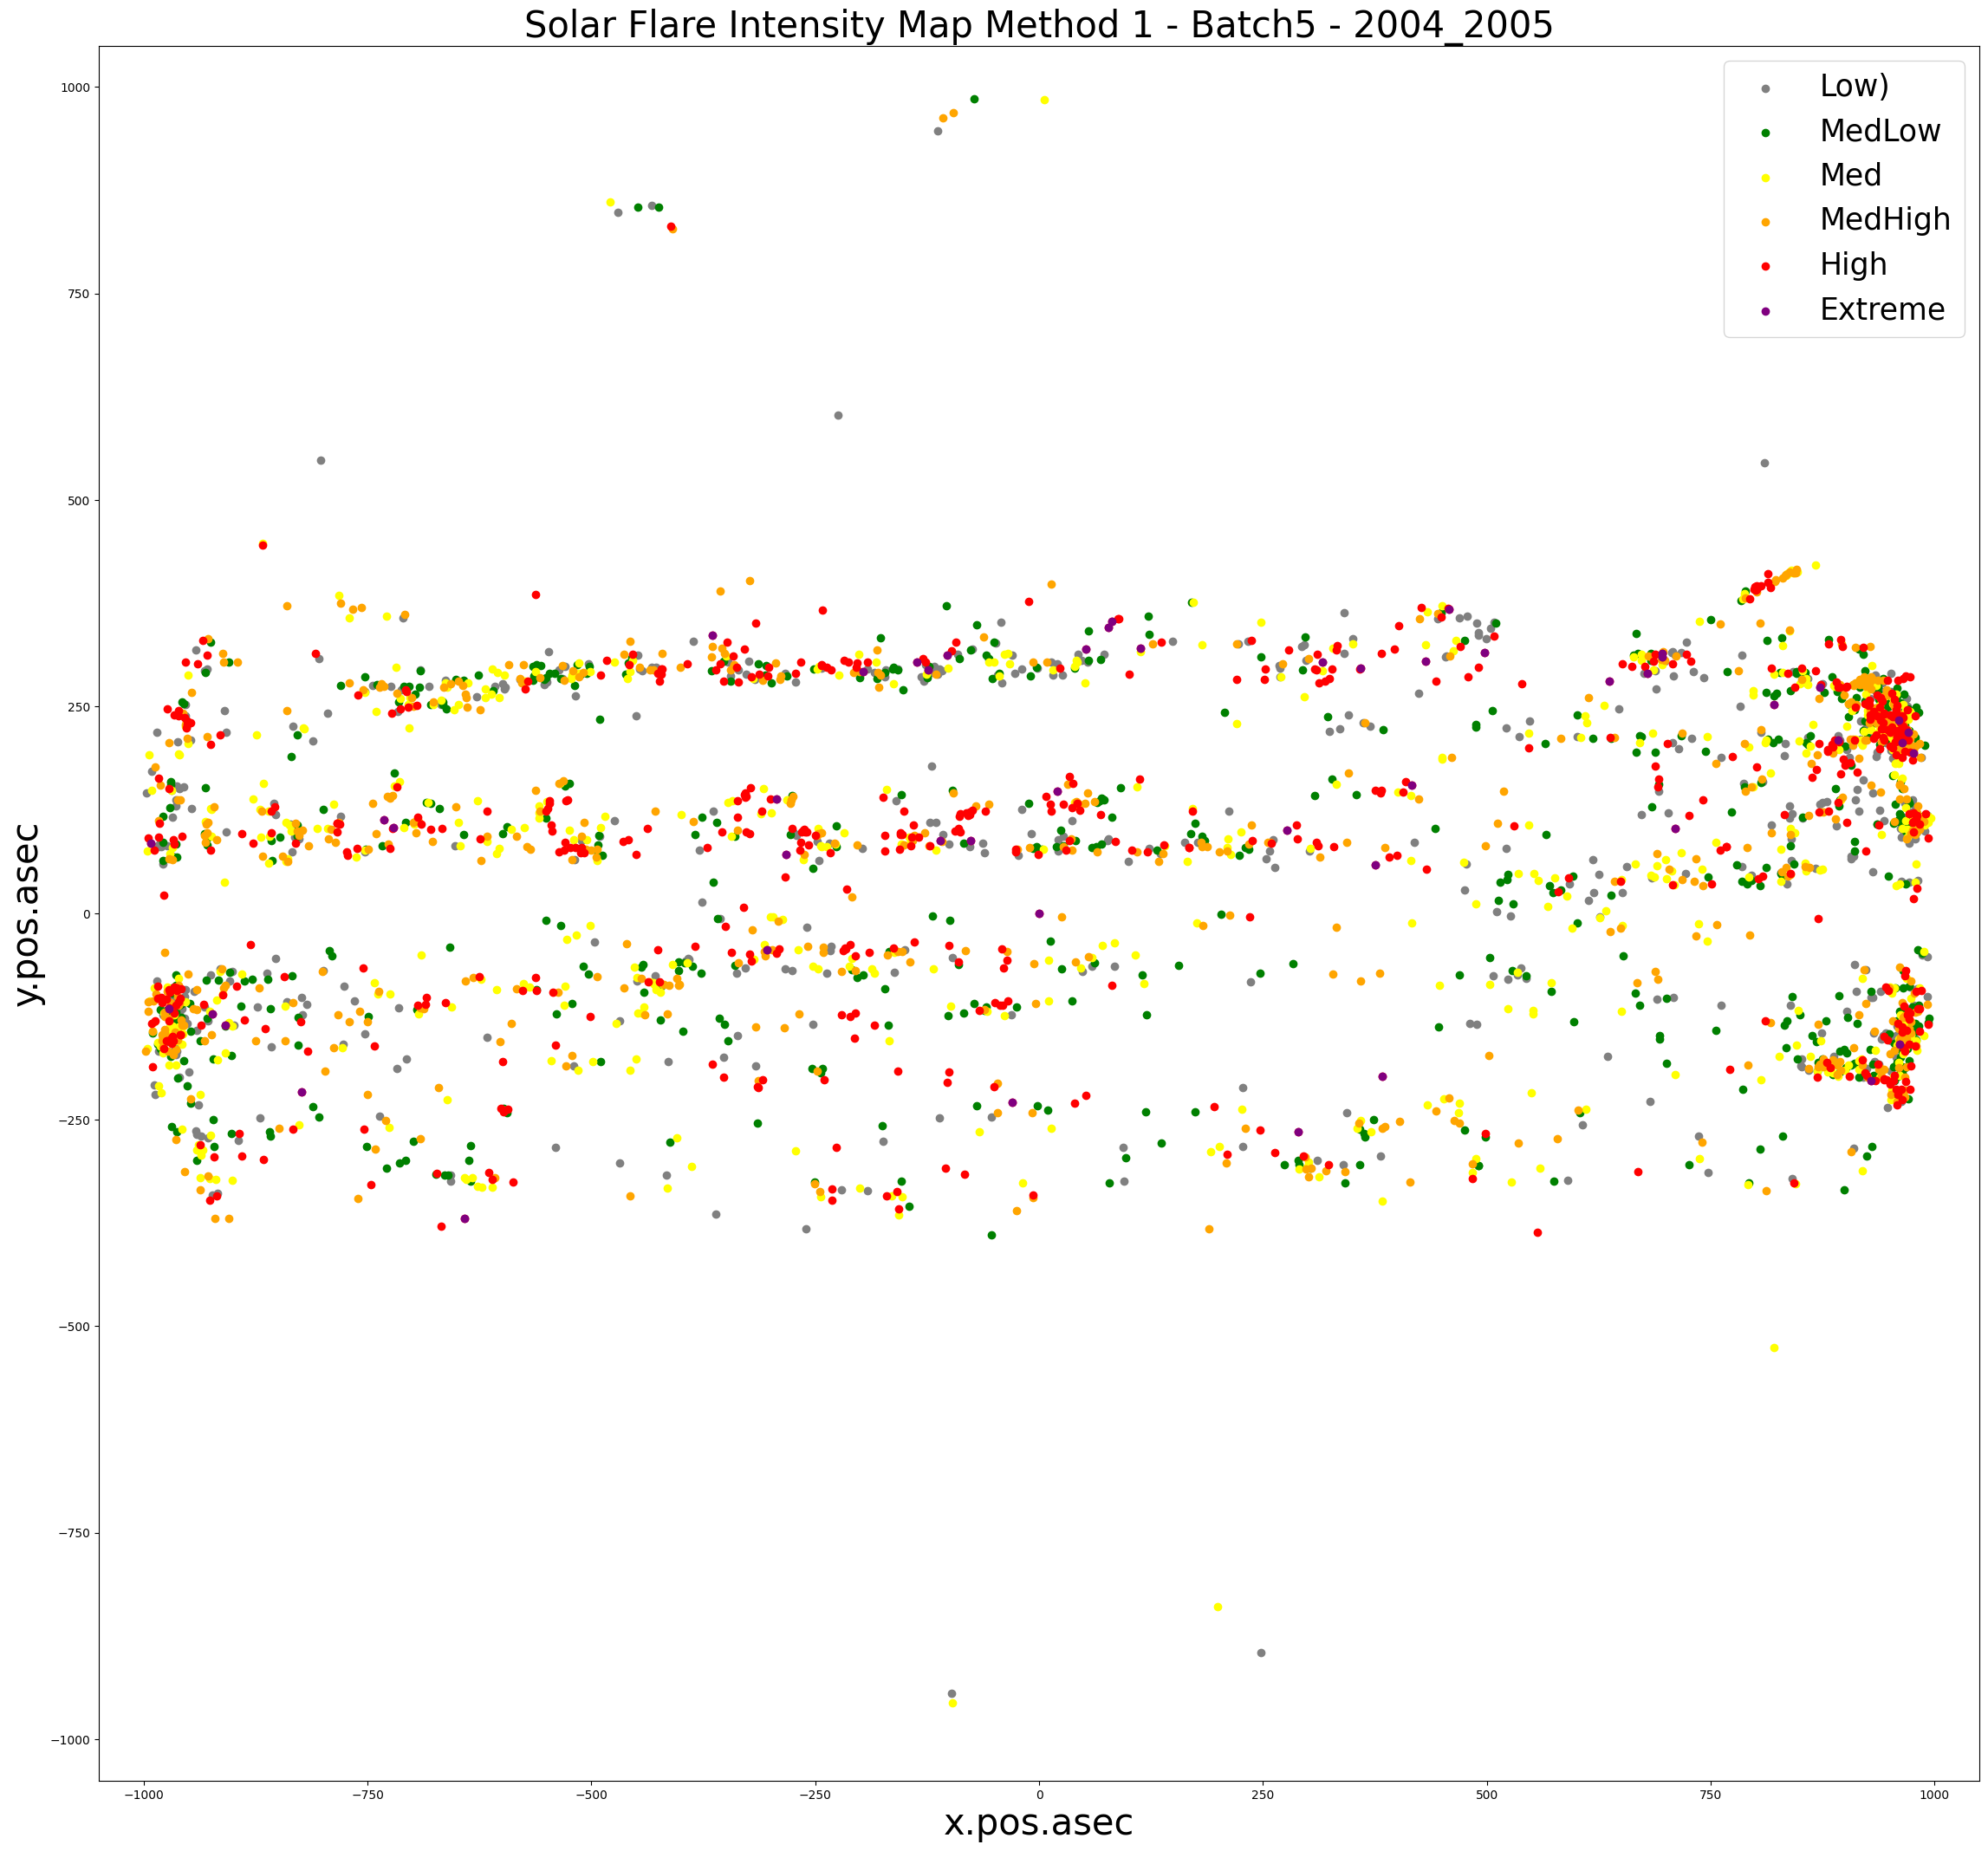

Method 2 - Batch5 - 2004_2005 

Low: 524 MedLow: 527 Med: 594 MedHigh: 673 High: 699 Extreme: 34 

Total:  3051 



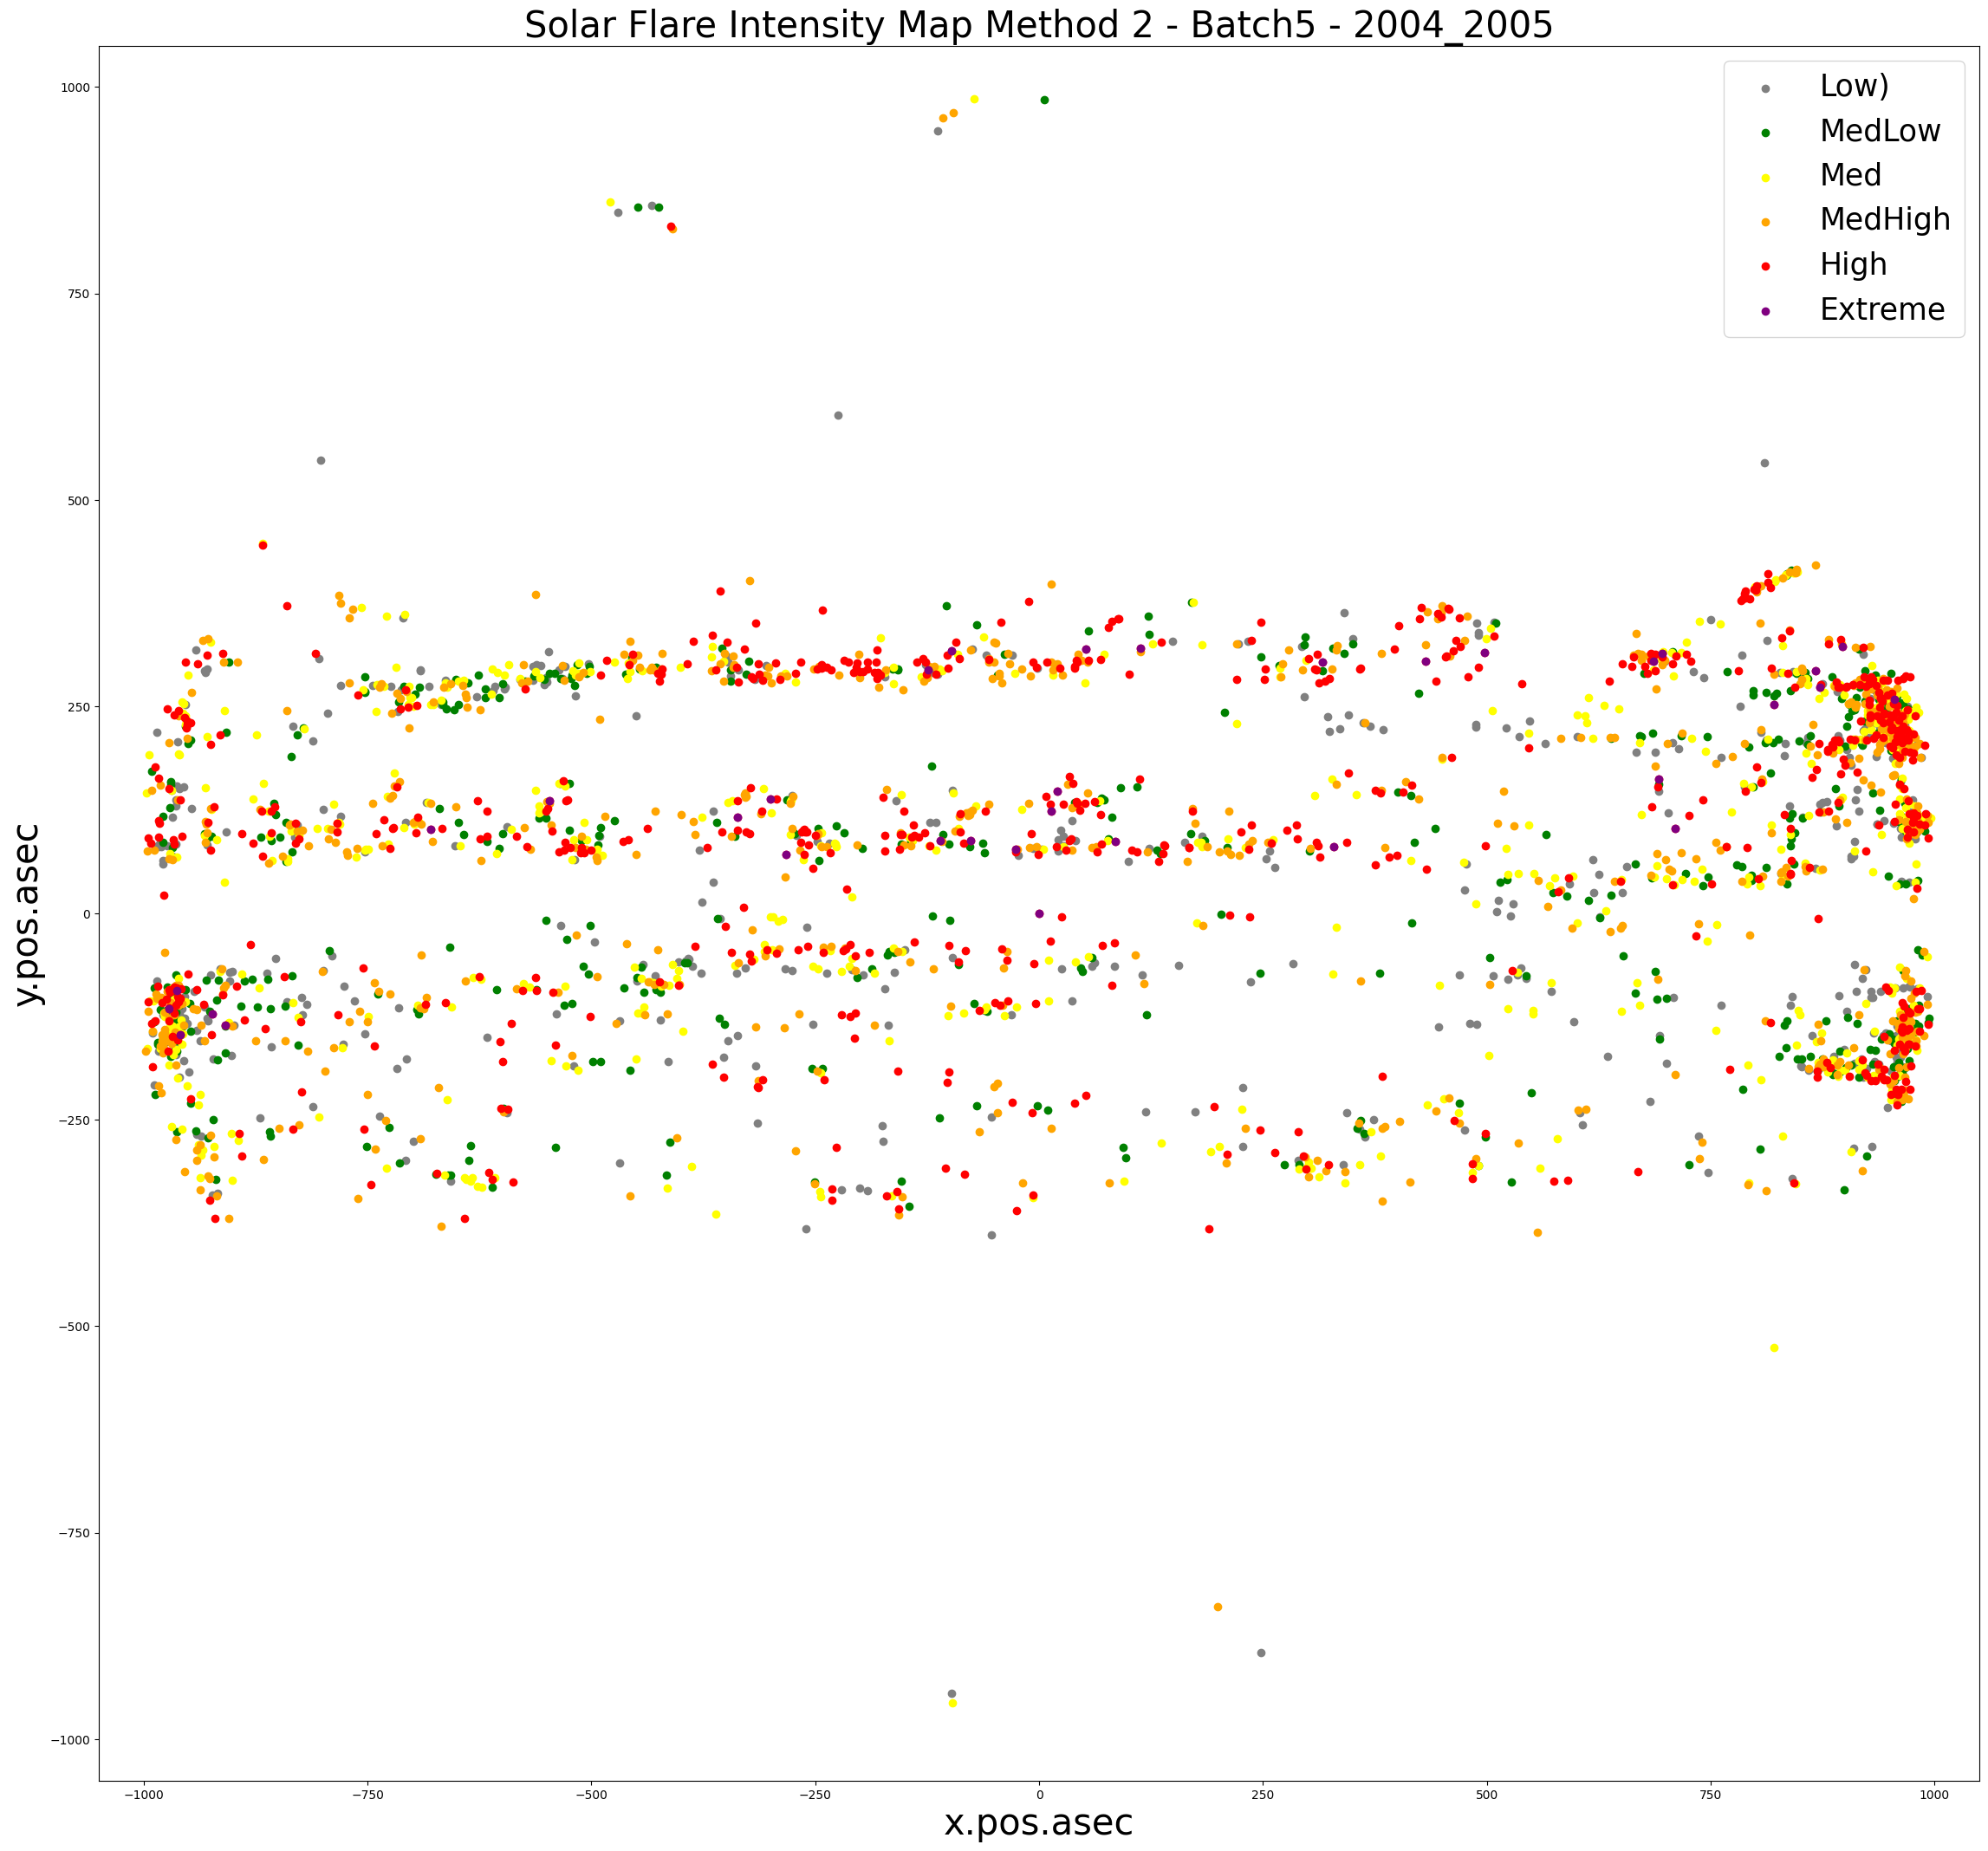

In [9]:
# Batch 5
intensity_map_scatter(batch5_method1_2004_2005, solar["total.counts"], 'Method 1','Batch5', '2004_2005', transparent=False)
intensity_map_scatter(batch5_method2_2004_2005, solar["intensity"], 'Method 2','Batch5', '2004_2005', transparent=False)

In [15]:
# Function to map the colors for the intensity
def map_intensity_to_color(intensity, splits):
    if intensity <= splits[0]:
        return 'grey'
    elif splits[0] < intensity <= splits[1]:
        return 'green'
    elif splits[1] < intensity <= splits[2]:
        return 'yellow'
    elif splits[2] < intensity <= splits[3]:
        return 'orange'
    elif splits[4] > intensity > splits[3]:
        return 'red'
    elif intensity > splits[4]:
        return 'purple'
    else:
        return 'unknown'

# Function to make the pngs for each date
# batch_method_pred is batchN_methodN_startyear_endyear
# batch_num is the respective batch number
# solar_data is the truth data from the solar either intensity calculated or total.counts.
# Method 1 requires solar["total.counts"] and Method 2 requires solar["intensity"]
# Please specify exactly the method_name, batch_name, year as follows:
# method_name = 'Method 2'
# batch_name = 'Batch0'
# year = 2004_2005
def intensity_map_png_maker(batch_method_pred, solar_data, batches, batch_num , method_name, batch_name, year):
    split_intense = split(solar_data)

    # Make the dates
    batch_method_pred['date'] = batches[batch_num].apply(lambda row: f"{row['year']}-{row['month']:02d}-{row['day']:02d}", axis=1)
    unique_dates = batch_method_pred['date'].unique()

    # Create a new column 'color' based on intensity levels
    batch_method_pred['color'] = batch_method_pred['intensity_pred'].apply(map_intensity_to_color, splits=split_intense)

    colors = {
        'low': 'grey',
        'medlow': 'green',
        'med': 'yellow',
        'medhigh': 'orange',
        'high': 'red',
        'extreme': 'purple'
    }
    
    # Create the labels for legend
    legend_patches = []
    for key in colors:
        patch = mpatches.Patch(color=colors[key], label=key)
        legend_patches.append(patch)

    # Create a scatter plot for each date as a PNG and JPEG
    for date in unique_dates:
        # Filter data for the current date
        filtered_data = batch_method_pred[batch_method_pred['date'] == date]

        # Create the scatter plot
        plt.figure(figsize=(28, 26))
        plt.text(0.05, 0.95, date, transform=plt.gca().transAxes, fontsize=40,
                bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))
        plt.title(f"Solar Flare Intensity Map {method_name} - {batch_name} - {year}", backgroundcolor='white', fontsize=30)
        plt.xlabel('x.pos.asec', backgroundcolor='white', fontsize=30)
        plt.ylabel('y.pos.asec', backgroundcolor='white', fontsize=30)
        plt.xlim(-1050, 1050)
        plt.ylim(-1050, 1050) 


        # Create a circle for the sun
        circle = mpatches.Circle((0, 0), radius=1020, color='black', alpha=1)
        plt.gca().add_patch(circle)

        plt.scatter(filtered_data['x.pos.asec'], filtered_data['y.pos.asec'], c=filtered_data['color'], s=15)
        
        plt.legend(handles=legend_patches, loc='upper right', fontsize=25)

        # Save the plots as a png to folder
        folder_path = f"{method_name} {batch_name} {year} pngs"
        os.makedirs(folder_path, exist_ok=True) # Make folder if it doesn't exist
        filename = os.path.join(folder_path, f'{date}.png')
        plt.savefig(filename, transparent=True)

        plt.close()


In [ ]:
# Make the pngs for the batches
# batch0 2004_2005
intensity_map_png_maker(batch0_method1_2004_2005, solar["total.counts"], batches2004_2005, 0 , 'Method 1', 'Batch0', '2004_2005')
intensity_map_png_maker(batch0_method2_2004_2005, solar["intensity"], batches2004_2005, 0 , 'Method 2', 'Batch0', '2004_2005')
# batch10 2004_2005
intensity_map_png_maker(batch10_method1_2004_2005, solar["total.counts"], batches2004_2005, 10 , 'Method 1', 'Batch10', '2004_2005')
intensity_map_png_maker(batch10_method2_2004_2005, solar["intensity"], batches2004_2005, 10 , 'Method 2', 'Batch10', '2004_2005')

# batch0 2015_2016
intensity_map_png_maker(batch0_method1_2015_2016, solar["total.counts"], batches2015_2016, 0 , 'Method 1', 'Batch0', '2015_2016')
intensity_map_png_maker(batch0_method2_2015_2016, solar["intensity"], batches2015_2016, 0 , 'Method 2', 'Batch0', '2015_2016')
# batch10 2015_2016
intensity_map_png_maker(batch10_method1_2015_2016, solar["total.counts"], batches2015_2016, 10 , 'Method 1', 'Batch10', '2015_2016')
intensity_map_png_maker(batch10_method2_2015_2016, solar["intensity"], batches2015_2016, 10 , 'Method 2', 'Batch10', '2015_2016')


In [ ]:
# batch0 2004_2005
intensity_map_png_maker(batch0_method1_2004_2005, solar["total.counts"], batches2004_2005, 0 , 'Method 1', 'Batch0', '2004_2005')

In [ ]:
# batch0 2015_2016
intensity_map_png_maker(batch0_method1_2015_2016, solar["total.counts"], batches2015_2016, 0 , 'Method 1', 'Batch0', '2015_2016')

In [ ]:
# Batch 5 Pngs
intensity_map_png_maker(batch5_method1_2004_2005, solar["total.counts"], batches2004_2005, 5 , 'Method 1', 'Batch5', '2004_2005')
intensity_map_png_maker(batch5_method2_2004_2005, solar["intensity"], batches2004_2005, 5 , 'Method 2', 'Batch5', '2004_2005')

In [26]:
#This code is adding the pngs together as a gif
def gif_maker(png_directory, output_gif, output_folder):
    #Makes sure GIFs folder exists
    os.makedirs(f"GIFs", exist_ok=True) 
    output_path = Path(output_folder)

    all_files = os.listdir(png_directory)
    gif_path = output_path / output_gif
    # List of PNG files
    png_files = sorted([f for f in all_files if f.endswith('.png')])
    
    # Creating the Combined GIF
    with imageio.get_writer(gif_path, duration = 350) as writer:
        for png_file in png_files:
            image_path = Path(png_directory) / png_file
            image = imageio.imread(image_path)
            writer.append_data(image)

    print(f'GIF succesffuly created: {output_gif}')


In [ ]:
# Batch 0 2004_2005 GIFs
gif_maker("Method 1 Batch0 2004_2005 pngs", "Method 1 Batch0 2004_2005.gif", "GIFs")
gif_maker("Method 2 Batch0 2004_2005 pngs", "Method 2 Batch0 2004_2005.gif", "GIFs")

# Batch 10 2004_2005 GIFs
gif_maker("Method 1 Batch10 2004_2005 pngs", "Method 1 Batch10 2004_2005.gif", "GIFs")
gif_maker("Method 2 Batch10 2004_2005 pngs", "Method 2 Batch10 2004_2005.gif", "GIFs")

# Batch 0 2015_2016 GIFs
gif_maker("Method 1 Batch0 2015_2016 pngs", "Method 1 Batch0 2015_2016.gif", "GIFs")
gif_maker("Method 2 Batch0 2015_2016 pngs", "Method 2 Batch0 2015_2016.gif", "GIFs")

# Batch 10 2015_2016 GIFs
gif_maker("Method 1 Batch10 2015_2016 pngs", "Method 1 Batch10 2015_2016.gif", "GIFs")
gif_maker("Method 2 Batch10 2015_2016 pngs", "Method 2 Batch10 2015_2016.gif", "GIFs")

In [ ]:
# Batch 5 2004_2005 GIFs
gif_maker("Method 1 Batch5 2004_2005 pngs", "Method 1 Batch5 2004_2005.gif", "GIFs")
gif_maker("Method 2 Batch5 2004_2005 pngs", "Method 2 Batch5 2004_2005.gif", "GIFs")

In [17]:
#This code is adding the pngs together as a mp4
def mp4_maker(png_directory, output_mp4, output_folder):
    #Makes sure MP4s folder exists
    os.makedirs(f"MP4s", exist_ok=True) 
    output_path = Path(output_folder)

    all_files = os.listdir(png_directory)
    mp4_path = output_path / output_mp4
    # List of PNG files
    png_files = sorted([f for f in all_files if f.endswith('.png')])
    
    # Creating the Combined MP4
    with imageio.get_writer(mp4_path, fps = 4) as writer:
        for png_file in png_files:
            image_path = Path(png_directory) / png_file
            image = imageio.imread(image_path)
            writer.append_data(image)

    print(f'MP4 succesffuly created: {output_mp4}')


In [ ]:
# Batch 0 2004_2005 MP4s
mp4_maker("Method 1 Batch0 2004_2005 pngs", "Method 1 Batch0 2004_2005.mp4", "MP4s")
mp4_maker("Method 2 Batch0 2004_2005 pngs", "Method 2 Batch0 2004_2005.mp4", "MP4s")

# Batch 10 2004_2005 MP4s
mp4_maker("Method 1 Batch10 2004_2005 pngs", "Method 1 Batch10 2004_2005.mp4", "MP4s")
mp4_maker("Method 2 Batch10 2004_2005 pngs", "Method 2 Batch10 2004_2005.mp4", "MP4s")

# Batch 0 2015_2016 MP4s
mp4_maker("Method 1 Batch0 2015_2016 pngs", "Method 1 Batch0 2015_2016.mp4", "MP4s")
mp4_maker("Method 2 Batch0 2015_2016 pngs", "Method 2 Batch0 2015_2016.mp4", "MP4s")

# Batch 10 2015_2016 MP4s
mp4_maker("Method 1 Batch10 2015_2016 pngs", "Method 1 Batch10 2015_2016.mp4", "MP4s")
mp4_maker("Method 2 Batch10 2015_2016 pngs", "Method 2 Batch10 2015_2016.mp4", "MP4s")

In [ ]:
# Batch 0 2004_2005 MP4s
mp4_maker("Method 1 Batch0 2004_2005 pngs", "Method 1 Batch0 2004_2005.mp4", "MP4s")

In [ ]:
# Batch 0 2015_2016 MP4s
mp4_maker("Method 1 Batch0 2015_2016 pngs", "Method 1 Batch0 2015_2016.mp4", "MP4s")

In [ ]:
# Batch 5 2004_2005 MP4s
mp4_maker("Method 1 Batch5 2004_2005 pngs", "Method 1 Batch5 2004_2005.mp4", "MP4s")
mp4_maker("Method 2 Batch5 2004_2005 pngs", "Method 2 Batch5 2004_2005.mp4", "MP4s")

In [27]:
# Batch 5 2004_2005 GIFs
gif_maker("Method 1 Batch5 2004_2005 pngs", "Method 1 Batch5 2004_2005.gif", "GIFs")

C:\Users\Npc\AppData\Local\Temp\ipykernel_26008\117350198.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


GIF succesffuly created: Method 1 Batch5 2004_2005.gif


In [ ]:
#Splitting data into low-high
#CHANGE y VALUE TO PREDICTED y
split1 = (np.percentile(y, 20))
split2 = (np.percentile(y, 40))
split3 = (np.percentile(y, 60))
split4 = (np.percentile(y, 80))
low = solar[(solar['total.counts'] <= split1)]
medlow = solar[(solar['total.counts'] > split1) & (solar['total.counts'] <= split2)]
med = solar[(solar['total.counts'] > split2) & (solar['total.counts'] <= split3)]
medhigh = solar[(solar['total.counts'] > split3) & (solar['total.counts'] <= split4)]
high = solar[(solar['total.counts'] > split4)]
medhighandhigh = solar[(solar['total.counts'] > split3)]

In [ ]:
#FULL KDE WITH NO ALTERATIONS
def graph(data):
    kde = gaussian_kde(data[['x.pos.asec', 'y.pos.asec']].transpose())
    data2 = np.vstack(data[['x.pos.asec', 'y.pos.asec']])
    xgrid = np.linspace(-1007, 1005, 100)
    ygrid = np.linspace(-998, 1012, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    plt.imshow(Z.reshape(Xgrid.shape), origin='lower', aspect='auto', extent=[-3.5, 3.5, -6, 6], cmap='magma')

In [ ]:
inD2Area = 0
inD1Area = 0
def graph(data, boole):
    #Call the KDE
    kde = gaussian_kde(data[['x.pos.asec', 'y.pos.asec']].transpose())
    data2 = np.vstack(data[['x.pos.asec', 'y.pos.asec']])
    # evaluate on a regular grid
    #Make a 100x100 grid
    xgrid = np.linspace(-1007, 1005, 100)
    ygrid = np.linspace(-998, 1012, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    #Use KDE to set values for each grid square
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    a = 0.0000005
    b = 0.0000011
    inD2Area = 0
    inD1Area = 0
    #Classify by whether within threshholds D1 and D2
    for i in range(0,10000):
        if Z[i] < a:
            Z[i] = 0
        elif Z[i] < b:
            Z[i] = 0.0000011
            inD2Area+=1
        else :
            Z[i] = 0.0000015
            inD1Area+=1
    #If boole is true graph will plot
    if boole:
        plt.imshow(Z.reshape(Xgrid.shape), origin='lower', aspect='auto', extent=[-3.5, 3.5, -6, 6], cmap='magma')

        plt.xlabel("Scaled x.pos.asec")
        plt.ylabel("Scaled y.pos.asec")
        plt.title("Hotspots Estimation")

    return [inD1Area, inD2Area]

In [ ]:
d1Val=[]
d2Val=[]
d1andd2val=[]
for i in range(0,11):
    temp = M1.predict(batches2004_2005[i][['duration.s', 'peak.c/s', 'x.pos.asec',
           'y.pos.asec', 'radial', 'energy.kev.i',
           'energy.kev.f', 'day','month','year','active.region.ar']])
    Tempbatch = batches2004_2005[i].copy()
    Tempbatch['M1_predict'] = temp
    split3 = (np.percentile(y, 60))
    medhighandhigh = Tempbatch[(Tempbatch['M1_predict'] > split3)]
    KDEModel = graph(medhighandhigh, False)
    print(KDEModel[0]/10000)
    print(KDEModel[1]/10000)
    d2Val.append(KDEModel[1]/10000)
    d1Val.append(KDEModel[0]/10000)
    d1andd2Val.append(KDEModel[0]/10000+KDEModel[1]/10000)
#plot = plt.figure()
plt.plot(d1Val, marker=".", markersize=10, label = 'D1')
plt.plot(d2Val, marker=".", markersize=10, label = 'D2')
plt.plot(d1andd2Val, marker=".", markersize=10, label = 'D1+D2')
plt.xlabel("Batch Number")
plt.ylabel("Proportion of Total Area")
plt.title("Area contained by D1 and D2")
ax = plt.gca()
ax.set_ylim([0, .2])
plt.legend()

plt.scatter(d1Val, d2Val, label = 'D1+D2')
plt.xlabel("D1")
plt.ylabel("D2")
plt.title("Area contained by D1 and D2")

Results (M1):
XGBRegressor(learning_rate= 0.248, max_depth= 10, n_estimators= 546)

Mean MAE: 138029.805 (17625.737)
RandomForestRegressor()

Mean MAE: 139686.422 (17620.332)
Pipeline( [('poly' , PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)), ('lin_r', LinearRegression()) ])

Mean MAE: 282348.380 (253154.974)
SVR()

Mean MAE: 347294.496 (35389.136)
slr = Pipeline([('scaler', RobustScaler()),('svr',SVR(max_iter = 100000))])

Mean MAE: 347933.764 (35413.271)
Pipeline([('scaler', RobustScaler()), ('linear', LinearRegression(fit_intercept = False))])

Mean MAE: 356138.574 (17816.858)
Pipeline(steps=[('robust', RobustScaler()), ('ridge', Ridge(alpha=9.391053524878311, tol=0.000841380674450156))])

Mean MAE: 402379.564 (16763.954)
LinearRegression()

Mean MAE: 402429.099 (16769.803)
ridge = Ridge(alpha=8.501992226787863, tol=0.0007708353644612364)

Mean MAE: 402429.088 (16769.796)

Results (M2):
XGBRegressor(learning_rate= 0.0597, max_depth= 4, n_estimators= 229)

Mean MAE: 3971.186 (170.351)
RandomForestRegressor()

Mean MAE: 4162.393 (193.812)
Pipeline([('poly' , PolynomialFeatures(degree = 3, include_bias = False, interaction_only = True)), ('lin_r', LinearRegression())])

Mean MAE: 3157.079 (102.188)
LinearRegression()

Mean MAE: 3262.677 (100.384)
Ridge(alpha=9.739625063533492, tol=7.842778538788441e-05)

Mean MAE: 3262.677 (100.384)
Pipeline(steps=[('standard', StandardScaler()), ('ridge', Ridge(alpha=1.157737190630861, tol=0.0008946473923448764))])

Mean MAE: 3262.680 (100.384)

In [ ]:
'''
We make the mean_absolute_error negative because scikit-learn assumes a higher number is better for scoring.
That's why we take the absolute value of our score at the end.
A lower MAE is better!
'''
def cv(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    #for cross_val being used:
    scores = np.absolute(scores)
    print(scores)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )



"""
The different search algo's benefits:

RandomizedSearchCV
    + less computationally expensive than GridSearchCV
    - not as robust(?) as GridSearchCV

GridSearchCV
    - computationally expensive
    - does not do well with large param list

HalvingGridSearchCV
    + less computationally expensive
    + does some battle royal stuff to narrow search pool
    - for complex models and param lists
"""
def grid(model, params):
    grid_search = RandomizedSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error',
                                     verbose=10, n_jobs=10, return_train_score=True)
    grid_search.fit(X_train, y_train)
    print("\n The best estimator:\n", grid_search.best_estimator_)
    print("\n The best score:\n", grid_search.best_score_)
    print("\n The best parameters:\n", grid_search.best_params_)



"""
XGBoost is known as one of the strongest models.

XGBoost Notes:
- when we changed the scoring within our gridsearch to 'neg_mean_absolute_error' the hyperparameters performed better

RandomForest Notes:
- base model performed just as well as optimized XGBoost, ffs
- RandomForest after gridSearch performed worse than base model

polynomial regression:
- takes up a lot of memory (failed some fits during hyperparameter tuning because of this)
- need to kernel trick features (feature space mapping)


scaling vs. centering
- scaling is when we want to transform our values to a specific range (everything's got similar magnitudes)
- centering is shifting values so they have a mean of 0 (subtract mean of feature from every value)

linear Regression:
- slow without scaling (probably)
- linear Regression also performed essentially the same with and without scaling, this brought to my attention
the fact that scikit-learn has it's own internal normalization step during training.
- for M1, when fit_intercept = False, standardScaler pipeline failed, but RobustScaler did better than
base linear Regression & base Robust linear Regression (interesting, wonder if has to do with the centering done by
RobustScaler & it's ability to handle data with outliers)

ridge Regression:
- ridge regression is less sensitive to magnitude (both types of scaled & unscaled data got same result)
- performed better on M1 than M2, standardScaler performed better than RobustScaler on M1 as well


RobustScaler vs StandardScaler
- Robust uses median & IQR
- Standard uses mean & standard deviation
- Robust is good for outlier heavy dataset, Standard is not

Support Vector Machine:
- Very computationally expensive.
- Oddly enough, using RobustScaler on the data resulted in a worse MAE

Thoughts on results:
- The dataset seems to be complex, the performance of the linear model and it's variations
does not compare to the tree algorithms
"""
#xg= XGBRegressor(learning_rate= 0.248, max_depth= 10, n_estimators= 546)
#Mean MAE: 138029.805 (17625.737)


xgr = Pipeline([('poly' , PolynomialFeatures(degree = 3, include_bias = False, interaction_only = True)), ('lin_r', LinearRegression())])

'''
example of the params_list for the XGBRegressor() model
used for RandomizedSearchCV
'''
xg_params = {
    'n_estimators' : randint(100,1201),
    'max_depth' : randint(1,11),
    'learning_rate' : uniform(0.001, 0.3)
}

#Next task:

slr = Pipeline([('scaler', RobustScaler()),('svr',SVR(max_iter = 100000))])
#main:

cv(xgr)

In [ ]:
#Task 3 Calculations

#method 2 average intensity for set 1
solar_2004_2005['intensity'].describe()
#method 2 average intensity for set 2
solar_2015_2016['intensity'].describe()
# Find the average intensity and total observations for batch 0 of 2004 and 2015
batch0_method1_2004_06_05 = batch0_method1_2004_2005[(batch0_method1_2004_2005['date'] >= '2004-01-06') & (batch0_method1_2004_2005['date'] <= '2004-01-15')]
batch0_method1_2015_03_12 = batch0_method1_2015_2016[(batch0_method1_2015_2016['date'] >= '2015-01-03') & (batch0_method1_2015_2016['date'] <= '2015-01-12')]
print("Avg Intensity 2005-06-15:", sum(batch0_method1_2004_06_05['intensity_pred'])/len(batch0_method1_2004_06_05['intensity_pred']))
print("Total Observation 2005-06-15:", len(batch0_method1_2004_06_05['intensity_pred']))
print("Avg Intensity 2015-03-12:", sum(batch0_method1_2015_03_12['intensity_pred'])/len(batch0_method1_2015_03_12['intensity_pred']))
print("Total Observation 2015-03-12:", len(batch0_method1_2015_03_12['intensity_pred']))
